<a href="https://colab.research.google.com/github/softwareeng1/Acquiring-financial-data/blob/main/Dataprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
import yfinance as yf
import pandas as pd
import numpy as np

In [29]:
df = yf.download('AAPL',
                 start='2010-01-01',
                 end='2021-01-01',
                 progress=False)
#Keep adjusted close prices only
df = df.loc[ :,['Adj Close']]


In [30]:
#calculate simple and log returns
df['simple_rtrn'] = df['Adj Close'].pct_change()
df['log_rtrn'] = np.log(df['Adj Close']/df['Adj Close'].shift(1))
df = df.dropna()
df.head()


,Adj Close,simple_rtrn,log_rtrn
Date,,,
2010-01-05,6.473147,0.001729,0.001727
2010-01-06,6.370184,-0.015906,-0.016034
2010-01-07,6.358407,-0.001849,-0.001850
2010-01-08,6.400681,0.006648,0.006626
2010-01-11,6.344217,-0.008821,-0.008861


# Adjusting For Inflation

In [12]:
!pip install Nasdaq-Data-Link

In [13]:
import nasdaqdatalink
import pandas as pd


In [14]:
nasdaqdatalink.ApiConfig.api_key = 'placeholder for api key'

In [15]:
df = df.resample('M').last()

In [16]:
df_cpi = nasdaqdatalink.get(
    dataset = "FRED/CPIAUCSL", # Changed the dataset code to a valid one
    start_date = '2010-01-01',
    end_date = '2021-01-01').rename(columns = {'Value':'cpi'})

`USING OTHER METHODS TO GET CPI DATA`

In [17]:
df_cpi

,cpi
Date,
2010-01-01,217.488
2010-02-01,217.281
2010-03-01,217.353
2010-04-01,217.403
2010-05-01,217.290
...,...
2020-09-01,260.190
2020-10-01,260.352
2020-11-01,260.721


In [1]:
!pip install cpi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.0/32.0 MB 10.6 MB/s eta 0:00:00


In [2]:
import cpi

In [3]:
cpi.update()
cpi_series = cpi.series
cpi_series =cpi_series.get()

In [4]:
df = cpi_series.to_dataframe()

In [5]:
df.query('period_type == "monthly" and year >= 2010') \
.loc[:,["date", "value"]] \
.set_index('date') \
.head(12)

,value
date,
2010-01-01,216.687
2010-02-01,216.741
2010-03-01,217.631
2010-04-01,218.009
2010-05-01,218.178
2010-06-01,217.965
2010-07-01,218.011
2010-08-01,218.312
2010-09-01,218.439


#Changing the frequency of time series data

In [22]:
import numpy as np
import pandas as pd #Import pandas

#Define the function calculating realized volatility
def realized_volatility(x):
    # Convert the 'value' column to numeric type, handling errors by converting invalid values to NaN
    x['value'] = pd.to_numeric(x['value'], errors='coerce')
    # Calculate the realized volatility using the 'value' column
    return np.sqrt(np.sum(x['value']**2))

#calculate monthly volatility
df_rv = (
df.groupby(pd.Grouper(freq="M"))
.apply(realized_volatility)
# Rename the resulting Series to 'rv'
.rename("rv")
)

In [24]:
#Anualize values
df_rv = df_rv * np.sqrt(12) # Directly access the values in the Series using its index.

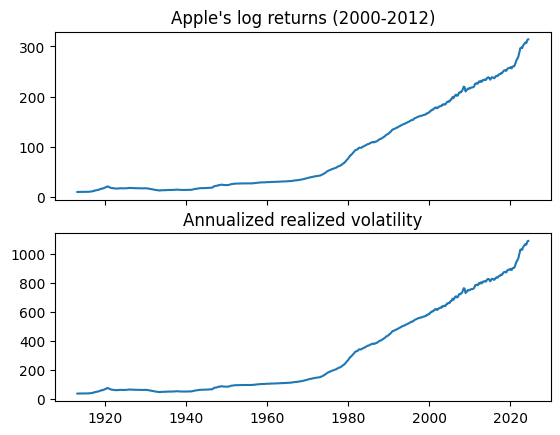

In [31]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 1, sharex=True)
# Plot the 'value' column from df against its index
ax[0].plot(df.index, df['value']) # Assuming 'value' contains the numerical data you want to plot
ax[0].set_title("Apple's log returns (2000-2012)")
ax[1].plot(df_rv)
ax[1].set_title("Annualized realized volatility")
plt.show()

#Imputing Missing data

In [33]:
import pandas as pd
import numpy as np
import nasdaqdatalink

# Download the inflation data from nasdaqdatalink

nasdaqdatalink.ApiConfig.api_key = 'place holder for api key'
df = (
    nasdaqdatalink.get(
    dataset = "FRED/CPIAUCSL",
    start_date = '2010-01-01',
    end_date = '2021-01-01'
    ).rename(columns = {'Value':'cpi'})
    )

In [41]:
#introduce 5 missing values
np.random.seed(42)
rand_indices  = np.random.choice(df.index, 5, replace=False)
df["cpi_missing"] = df.loc[:, "cpi"]
df.loc[rand_indices, "cpi_missing"] = np.nan
df.head()

,cpi,cpi_missing
Date,,
2010-01-01,217.488,217.488
2010-02-01,217.281,217.281
2010-03-01,217.353,217.353
2010-04-01,217.403,217.403
2010-05-01,217.290,217.290


In [43]:
#Check if there are missing values
df.isnull().values.any()

True

In [44]:
#fill using different methods
for method in ["bfill", "ffill"]:
    df[f"method_{method}"] = df["cpi_missing"].fillna(method=method)

In [46]:
#inspect the results by displaying the rows in which we created missing values
df.loc[rand_indices].sort_index()

,cpi,cpi_missing,method_bfill,method_ffill
Date,,,,
2012-08-01,229.918,NaN,231.015,228.590
2013-07-01,232.900,NaN,233.456,232.445
2014-04-01,236.468,NaN,236.918,236.028
2015-10-01,237.733,NaN,238.017,237.498
2019-10-01,257.305,NaN,257.788,256.596


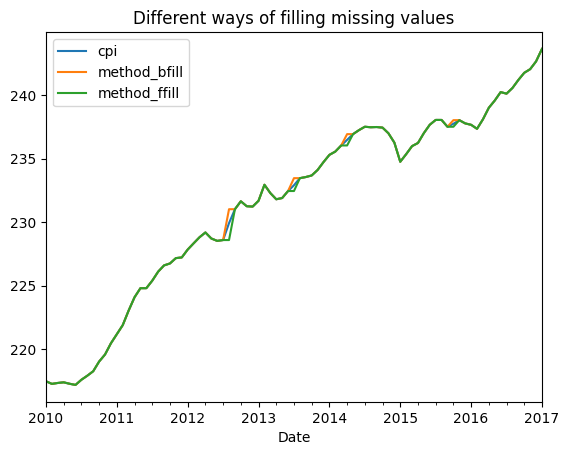

In [48]:
#plot the results for the years  2015 to 2016
df.loc[:"2017-01-01"] \
.drop(columns=["cpi_missing"]) \
.plot(title="Different ways of filling missing values");